In [182]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

import time
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import scipy as sc

from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt

# Check the images

In [165]:
images = glob.glob('vehicles/*/*.png')
cars = []
notcars = []
for image in images:
    cars.append(image)

images = glob.glob('non-vehicles/*/*.png')
for image in images:
    notcars.append(image)
    
#### TODO: For production: remove that  
# images = glob.glob('vehicles_smallset/*/*.jpeg')
# cars = []
# notcars = []
# for image in images:
#     cars.append(image)

# images = glob.glob('non-vehicles_smallset/*/*.jpeg')
# for image in images:
#     notcars.append(image)

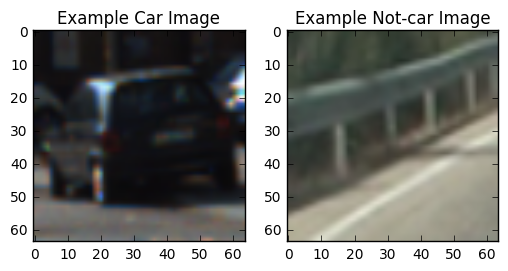

{'n_notcars': 9666, 'data_type': dtype('uint8'), 'image_shape': (64, 64, 3), 'n_cars': 8792}


In [166]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    test_image = sc.misc.imread(car_list[0]) #mpimg.imread(car_list[0])
    
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_image.dtype

    # Return data_dict
    return data_dict

data_info = data_look(cars, notcars)
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = sc.misc.imread(cars[car_ind]) #mpimg.imread(cars[car_ind])
notcar_image = sc.misc.imread(notcars[notcar_ind]) #mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

print(data_info)


# Get correct filters to use

In [209]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', cspacehog='HLS', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    convert =  isinstance(imgs[0], str)
#     min_val = 1000
#     max_val = 0
    # Iterate through the list of images
    for img in imgs:
        # Read in each one by one
        if convert:
            image = sc.misc.imread(img) #mpimg.imread(img)
        else:
            image = img
        
#         min_val = min(min_val, np.min(image))
#         max_val = max(max_val, np.max(image))
        
        # image = cv2.resize(image1, dsize = (142, 142))
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
            
        if cspacehog != 'RGB':
            if cspacehog == 'HSV':
                feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspacehog == 'LUV':
                feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspacehog == 'HLS':
                feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspacehog == 'YUV':
                feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspacehog == 'YCrCb':
                feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image_hog = np.copy(image)      
            
        # Apply bin_spatial() to get spatial color features
        #spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features_0 = get_hog_features(feature_image_hog[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        hog_features_1 = get_hog_features(feature_image_hog[:,:,1], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        hog_features_2 = get_hog_features(feature_image_hog[:,:,2], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        # features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        # features.append(hog_features)
        features.append(np.concatenate((hog_features_0, hog_features_1, hog_features_2, hist_features)))
    #print('minmax:', min_val, max_val)
    # Return list of feature vectors
    return features

def extract_feature_1_img(img, cspace='RGB', cspacehog='HLS', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    convert =  isinstance(img, str)

    # Read in each one by one
    if convert:
        image = sc.misc.imread(img) #mpimg.imread(img)
    else:
        image = img

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if cspacehog != 'RGB':
        if cspacehog == 'HSV':
            feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspacehog == 'LUV':
            feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspacehog == 'HLS':
            feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspacehog == 'YUV':
            feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspacehog == 'YCrCb':
            feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image_hog = np.copy(image)      

    # Apply bin_spatial() to get spatial color features
    #spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Call get_hog_features() with vis=False, feature_vec=True
    hog_features_0, hog_image_0 = get_hog_features(feature_image_hog[:,:,0], orient, 
                    pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    hog_features_1, hog_image_1 = get_hog_features(feature_image_hog[:,:,1], orient, 
                    pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    hog_features_2, hog_image_2 = get_hog_features(feature_image_hog[:,:,2], orient, 
                    pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    
    
    # Return list of feature vectors
    return hog_image_0, hog_image_1, hog_image_2, hist_features



In [168]:
_CSPACE_ = 'YCrCb'
_CSPACE_HOG_ = 'YCrCb'
_SPATIAL_SIZE_ = (8, 8)
_HIST_BINS_ = 32
_HIST_RANGE_ = (0, 256)
_ORIENT_ = 8
_PIX_PER_CELL_ = 8
_CELL_PER_BLOCK_ = 2
_HOG_CHANNEL_ = 1

In [169]:
car_features = extract_features(cars, cspace=_CSPACE_, cspacehog=_CSPACE_HOG_, spatial_size=_SPATIAL_SIZE_,
                        hist_bins=_HIST_BINS_, hist_range=_HIST_RANGE_, orient=_ORIENT_, pix_per_cell=_PIX_PER_CELL_, 
                        cell_per_block=_CELL_PER_BLOCK_, hog_channel=_HOG_CHANNEL_)
notcar_features = extract_features(notcars, cspace=_CSPACE_, cspacehog=_CSPACE_HOG_, spatial_size=_SPATIAL_SIZE_,
                        hist_bins=_HIST_BINS_, hist_range=_HIST_RANGE_, orient=_ORIENT_, pix_per_cell=_PIX_PER_CELL_, 
                        cell_per_block=_CELL_PER_BLOCK_, hog_channel=_HOG_CHANNEL_)
# notcar_features is a list
print(notcar_features[2].shape, notcar_features[0].shape, notcar_features[1].shape)
print(car_features[2].shape, car_features[0].shape, car_features[1].shape)


minmax: 0 255
minmax: 0 255
(4800,) (4800,) (4800,)
(4800,) (4800,) (4800,)


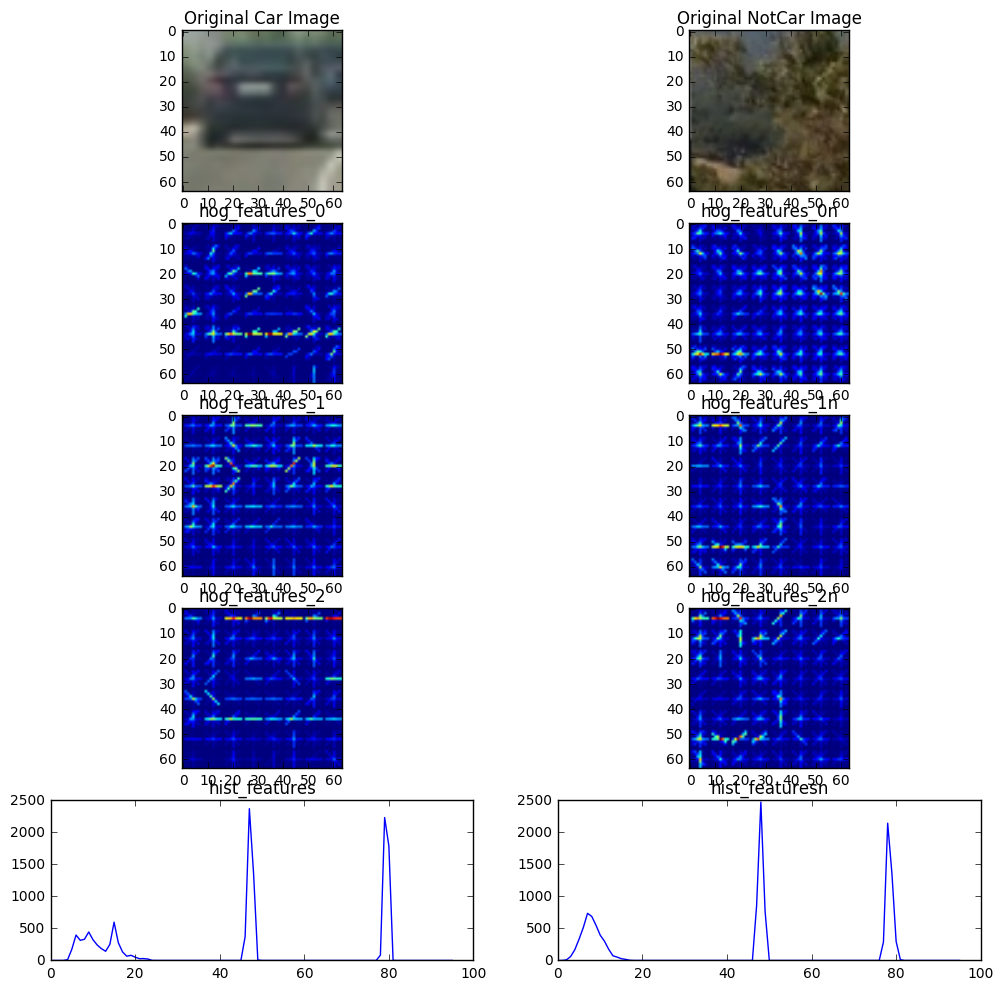

In [170]:
idx = 1

hog_image_0,  hog_image_1, hog_image_2, hist_features = extract_feature_1_img(cars[idx], cspace=_CSPACE_, cspacehog=_CSPACE_HOG_, spatial_size=_SPATIAL_SIZE_,
                        hist_bins=_HIST_BINS_, hist_range=_HIST_RANGE_, orient=_ORIENT_, pix_per_cell=_PIX_PER_CELL_, 
                        cell_per_block=_CELL_PER_BLOCK_, hog_channel=_HOG_CHANNEL_)
hog_image_0n,  hog_image_1n, hog_image_2n, hist_featuresn = extract_feature_1_img(notcars[idx], cspace=_CSPACE_, cspacehog=_CSPACE_HOG_, spatial_size=_SPATIAL_SIZE_,
                        hist_bins=_HIST_BINS_, hist_range=_HIST_RANGE_, orient=_ORIENT_, pix_per_cell=_PIX_PER_CELL_, 
                        cell_per_block=_CELL_PER_BLOCK_, hog_channel=_HOG_CHANNEL_)

imgplot = sc.misc.imread(cars[idx])
imgplotn = sc.misc.imread(notcars[idx])

fig = plt.figure(figsize=(12,12))

plt.subplot(521)
plt.imshow(imgplot)
plt.title('Original Car Image')
plt.subplot(523)
plt.imshow(hog_image_0)
plt.title('hog_features_0')
plt.subplot(525)
plt.imshow(hog_image_1)
plt.title('hog_features_1')
plt.subplot(527)
plt.imshow(hog_image_2)
plt.title('hog_features_2')
plt.subplot(529)
plt.plot(hist_features)
plt.title('hist_features')

plt.subplot(522)
plt.imshow(imgplotn)
plt.title('Original NotCar Image')
plt.subplot(524)
plt.imshow(hog_image_0n)
plt.title('hog_features_0n')
plt.subplot(526)
plt.imshow(hog_image_1n)
plt.title('hog_features_1n')
plt.subplot(528)
plt.imshow(hog_image_2n)
plt.title('hog_features_2n')
plt.subplot(5,2,10)
plt.plot(hist_featuresn)
plt.title('hist_featuresn')

plt.show()

# Train SVM

In [183]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
print(X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

(18458, 4800)


In [184]:
# Use a linear SVC 
svc = LinearSVC(C=1.0) # TODO: CHECK WHY 
clf = CalibratedClassifierCV(svc) # to know the actual probability
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', clf.score(X_train, y_train))
print('Test Accuracy of SVC = ', clf.score(X_test, y_test))
# Check the prediction time for a single sample
t=time.time()
prediction = clf.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with SVC')

############################################################
# HOG Channel 0
# 16.65935492515564 Seconds to train SVC...
# Train Accuracy of SVC =  0.979073547338
# Test Accuracy of SVC =  0.907638136511
# 0.00032591819763183594 Seconds to predict with SVC

# HOG Channel 1
# 28.72713303565979 Seconds to train SVC...
# Train Accuracy of SVC =  0.949681701205
# Test Accuracy of SVC =  0.895720476706
# 0.00035309791564941406 Seconds to predict with SVC

# HOG Channel 2
# 8.475466966629028 Seconds to train SVC...
# Train Accuracy of SVC =  0.999322768522
# Test Accuracy of SVC =  0.94420368364
# 0.00023102760314941406 Seconds to predict with SVC

# HOG Channel 2 is the best

############################################################
# spatial_features (32,32) and 3072 features!
# 34.66925501823425 Seconds to train SVC...
# Train Accuracy of SVC =  0.996410673168
# Test Accuracy of SVC =  0.866197183099
# 0.00034999847412109375 Seconds to predict with SVC

# spatial_features (16,16) and 768 features
# 19.1723690032959 Seconds to train SVC...
# Train Accuracy of SVC =  0.927400785589
# Test Accuracy of SVC =  0.893553629469
# 0.0002570152282714844 Seconds to predict with SVC
# The other one is clearly overfitting

# spatial_features (8,8) and 192 features 
# 7.849413871765137 Seconds to train SVC...
# Train Accuracy of SVC =  0.882161722877
# Test Accuracy of SVC =  0.870801733478
# 0.0002701282501220703 Seconds to predict with SVC

# spatial_features (16,16) seems to be the best (after being converted to HSV space)
############################################################

# hist_features _HIST_BINS_ = 16 => 48 features
# Train Accuracy of SVC =  0.830285791684
# Test Accuracy of SVC =  0.822860238353

# hist_features _HIST_BINS_ = 32 => 96 features
# 2.6299118995666504 Seconds to train SVC...
# Train Accuracy of SVC =  0.862047947989
# Test Accuracy of SVC =  0.855904658722
# 0.00028204917907714844 Seconds to predict with SVC
# getting better

# hist_features _HIST_BINS_ = 64 => 192 features
# 2.548999071121216 Seconds to train SVC...
# Train Accuracy of SVC =  0.927197616145
# Test Accuracy of SVC =  0.923618634886
# 0.0002930164337158203 Seconds to predict with SVC

# hist_features _HIST_BINS_ = 128 => 384 features
# Train Accuracy of SVC =  0.956183123392
# Test Accuracy of SVC =  0.955579631636
# 0.0002701282501220703 Seconds to predict with SVC


19.73079204559326 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.991061755146
0.0008051395416259766 Seconds to predict with SVC


# Sliding window

In [329]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0,  255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes

    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)

    # Return the image copy with boxes drawn
    return imcopy
    
# Here is your draw_boxes function from the previous exercise
def draw_boxes_proba(img, bboxes, probas, thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes

    for i, bbox in enumerate(bboxes):
        # print(bbox, bbox[0], type(bbox[0]))
        # Draw a rectangle given bbox coordinates
        prob = probas[i][1] # 0 is the class 0 and 1 is class 1

        if prob < .6:
            color = (255,204,204)
        elif prob < .7:
            color = (255,102,102)
        elif prob < .8:
            color = (153,0,0)
        elif prob < .8:
            color = (102,51,0)
        elif prob <= 1:
            color = (51,0,0)
        
        cv2.rectangle(imcopy, tuple(bbox[0]), tuple(bbox[1]), color, thick)

    # Return the image copy with boxes drawn
    return imcopy
    
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if (x_start_stop == [None, None]):
        x_start_stop=[0, img.shape[1]]
    if (y_start_stop == [None, None]):   
        y_start_stop=[0, img.shape[0]]
    
    # Compute the span of the region to be searched  
    xy_span = (x_start_stop[1] - x_start_stop[0], y_start_stop[1] - y_start_stop[0])
    
    # Compute the number of pixels per step in x/y
    xy_pixels_per_step = (int(xy_window[0]*(1-xy_overlap[0])), int(xy_window[1]*(1-xy_overlap[1])))
    
    # Compute the number of windows in x/y
    #xy_window_ct = (int(xy_span[0]/xy_pixels_per_step[0]), int(xy_span[1]/xy_pixels_per_step[1]))
    xy_window_ct = (int((xy_span[0] - xy_window[0])/xy_pixels_per_step[0]) + 1, 
                    int((xy_span[1] - xy_window[1])/xy_pixels_per_step[1]) + 1)
    
    # Initialize a list to append window positions to
    # print('y_stop:', y_start_stop[1], "y window ct:", xy_window_ct[1], "y pixels per step:", xy_pixels_per_step[1])
    missing_pixels = y_start_stop[1] - (y_start_stop[0] + xy_window[1] + (xy_window_ct[1] - 1)* xy_pixels_per_step[1])
    # print(missing_pixels)
    
    window_list = []
    # Loop through finding x and y window positions
    for x_ct in range(xy_window_ct[0]):
        for y_ct in range(xy_window_ct[1]):
            window_position_top_left = (x_start_stop[0] + x_ct * xy_pixels_per_step[0], missing_pixels + y_start_stop[0] + y_ct * xy_pixels_per_step[1])
            window_position_bottom_right = (window_position_top_left[0] + xy_window[0], window_position_top_left[1] + xy_window[1])
            window_list.append((window_position_top_left, window_position_bottom_right))

    return window_list



In [330]:
def get_window_recognition(image, xy_window, xy_overlap, y_start_stop=[None, None], color = (0, 0, 255), thick = 6):

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=xy_overlap)

#     window_img = draw_boxes(image, windows, color = (0, 0, 255), thick=6)                    
#     plt.imshow(window_img)
#     plt.show()

    window_images = []
    for i in range(len(windows)):
        # switch x and y!
        window_image = image[windows[i][0][1]:windows[i][1][1], windows[i][0][0]:windows[i][1][0], :]
        window_image = cv2.resize(window_image, dsize =(64,64))
        window_images.append(window_image)

    # plt.imshow(window_images[0])
    # plt.show()

#    print('len(window_images):', len(window_images))
    window_feature = extract_features(window_images, cspace=_CSPACE_, cspacehog=_CSPACE_HOG_, spatial_size=_SPATIAL_SIZE_,
                            hist_bins=_HIST_BINS_, hist_range=_HIST_RANGE_, orient=_ORIENT_, pix_per_cell=_PIX_PER_CELL_, 
                            cell_per_block=_CELL_PER_BLOCK_, hog_channel=_HOG_CHANNEL_)
    X_feature = np.asarray(window_feature).astype(np.float64) 

    # Apply the scaler to X
#    print('X_feature.shape:', X_feature.shape)
    scaled_X_feature = X_scaler.transform(X_feature)

    predictions = clf.predict(scaled_X_feature)
    probabilities = clf.predict_proba(scaled_X_feature)
    windows_pred = [windows[i] for i in range(len(windows)) if predictions[i] == 1 ]
    windows_probabilities = [probabilities[i] for i in range(len(windows)) if predictions[i] == 1 ]
#    print('len(predictions):', len(predictions), '// len(windows_pred):', len(windows_pred))

#     window_img = draw_boxes(image, windows_pred, color=color, thick=thick)                    
#     plt.imshow(window_img)
#     plt.show()

    return windows_pred, windows_probabilities

### For each sliding window, run the classifier

In [379]:
image = sc.misc.imread('bbox-example-image.jpg') #mpimg.imread('bbox-example-image.jpg')

def get_heatmap(image, windows_pred, windows_proba):

    heatmap = np.zeros_like(image[:,:,-1]).astype(np.float32)
#    print(heatmap.shape) # y (720) / x (1200)

    for i, w in enumerate(windows_pred):
        proba = windows_proba[i][1]
        heatmap[w[0][1]:w[1][1], w[0][0]:w[1][0]] = heatmap[w[0][1]:w[1][1], w[0][0]:w[1][0]] + 1 #proba

    print(np.min(heatmap), np.max(heatmap))

#     plt.imshow(heatmap, cmap = 'gray')
#     plt.show()

    heatmap[heatmap<=1] = 0

    # rescale between 0 and 255
    minheatmap = np.min(heatmap)
    maxheatmap = np.max(heatmap)

    heatmap2 = (heatmap * 255 / maxheatmap).astype(np.uint8)

#     plt.imshow(image)
#     plt.show()

    return heatmap2

def get_blob(heatmap):

    # blobs_log = blob_log(heatmap2, max_sigma=30, num_sigma=10, threshold=.1)

    # print(heatmap2.shape)
    # print(blobs_log.shape)

    # blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    # blobs_dog = blob_dog(heatmap2, max_sigma=30, threshold=.1)
    # blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

    if (np.max(heatmap) > 0):
    
        #blobs_doh = blob_doh(heatmap2, max_sigma=30, threshold=.002, overlap = .5)
        blobs_doh = blob_doh(heatmap, num_sigma=5, min_sigma=5, max_sigma=255, threshold=.005)
        # blobs = blob_doh(heatmap2, num_sigma=5, min_sigma=1, max_sigma=255, threshold=.005)
        return blobs_doh
    else:
        return []
    

def pipeline(image):
    window_img = np.copy(image)

    color_boxes = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]

    #windows_pred_1 = get_window_recognition(image = image, xy_window = (256, 256), xy_overlap = (0.8, 0.8), y_start_stop=[400, image.shape[0]], color = (0, 0, 255), thick = 6)
    windows_pred_2, windows_probabilities_2 = get_window_recognition(image = image, xy_window = (128, 128), xy_overlap = (0.8, 0.8), y_start_stop=[400, image.shape[0]], color = (0, 255, 0), thick = 6)
    windows_pred_3, windows_probabilities_3 = get_window_recognition(image = image, xy_window = (64, 64), xy_overlap = (0.8, 0.8), y_start_stop=[400, 600], color = (255, 0, 0), thick = 6)
    
    if len(windows_probabilities_2) > 0:
        if len(windows_probabilities_3) > 0:
            windows_proba = [windows_probabilities_2, windows_probabilities_3]
            windows_pred = [windows_pred_2, windows_pred_3] #windows_pred_1, 
        else: 
            windows_proba = [windows_probabilities_2]
            windows_pred = [windows_pred_2] #windows_pred_1,  
    else:
        windows_proba = [windows_probabilities_3]
        windows_pred = [windows_pred_3] #windows_pred_1,  
    
    # print(windows_probabilities_2)
    # print(windows_probabilities_3)
    # print(len(windows_probabilities_3), len(windows_probabilities_2)) 
    
    windows_proba = np.concatenate(windows_proba)
    windows_pred = np.concatenate(windows_pred)

    window_img = draw_boxes_proba(window_img, windows_pred, windows_proba, thick=6)  
     
    heatmap = get_heatmap(image, windows_pred, windows_proba)
    
    blobs = get_blob(heatmap)
     
    return window_img, windows_pred, windows_proba, heatmap, blobs



0.0 19.0


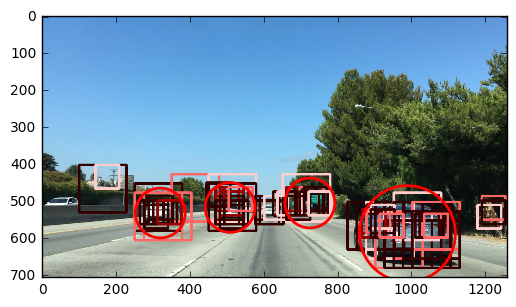

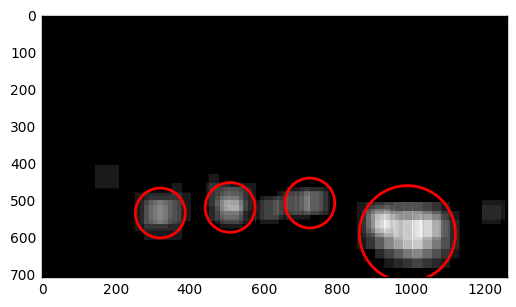

In [380]:
window_img, windows_pred, windows_proba, heatmap, blobs = pipeline(image = image)

# plt.imshow(window_img)
# plt.show() 

fig=plt.figure(1)
ax=fig.add_subplot(1,1,1)
ax.imshow(window_img)

for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
    ax.add_patch(c)

plt.show()


fig=plt.figure(1)
ax=fig.add_subplot(1,1,1)
ax.imshow(heatmap, cmap = 'gray')

for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
    ax.add_patch(c)

plt.show()


### Test on extracted images

0.0 1.0


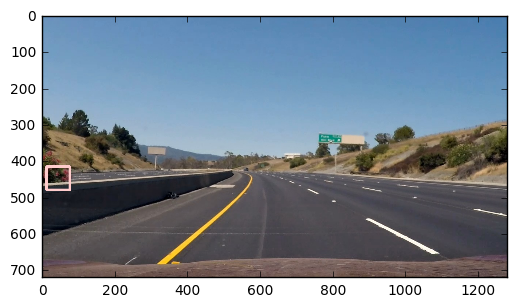

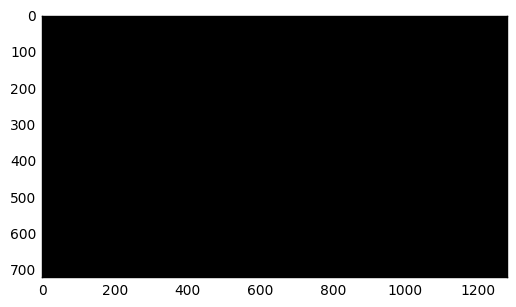

0.0 7.0


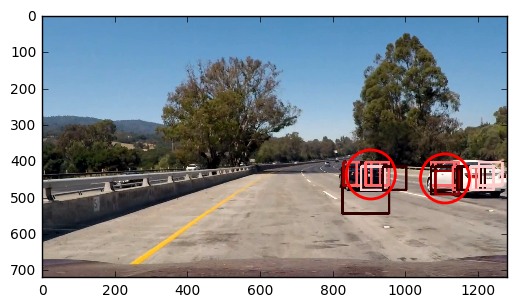

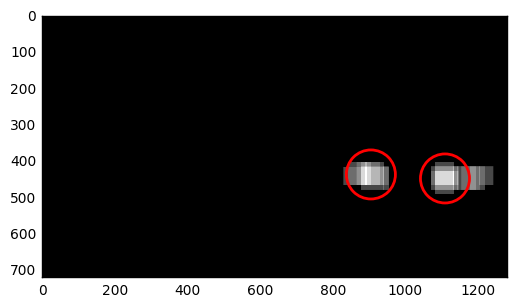

0.0 0.0


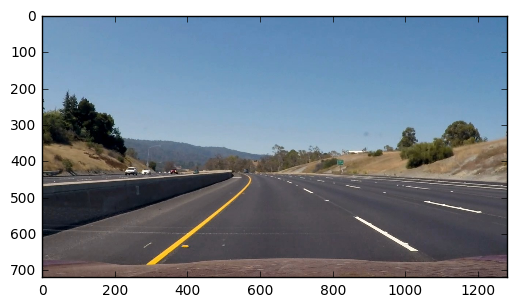

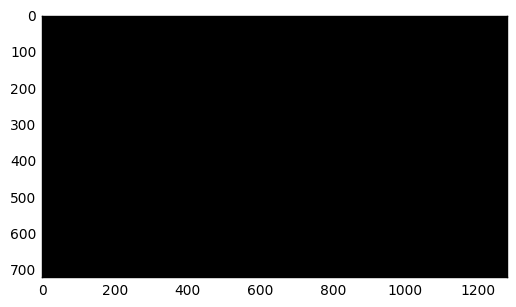

0.0 4.0


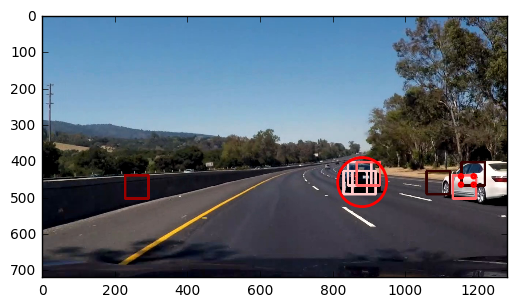

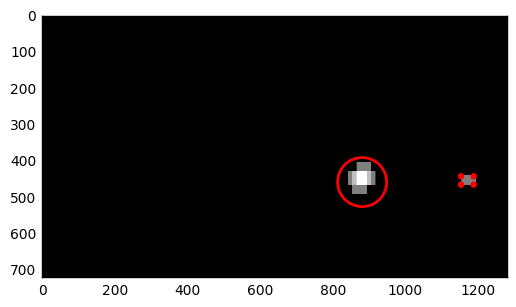

0.0 6.0


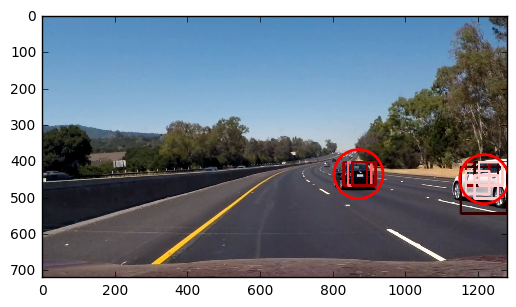

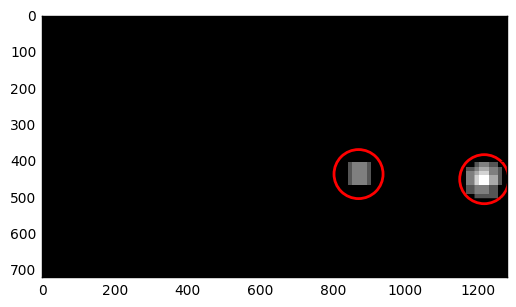

0.0 5.0


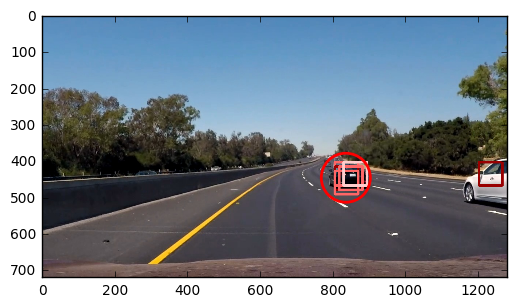

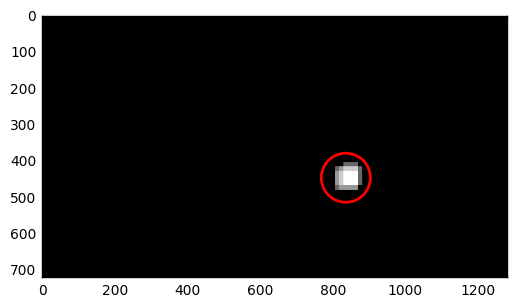

0.0 5.0


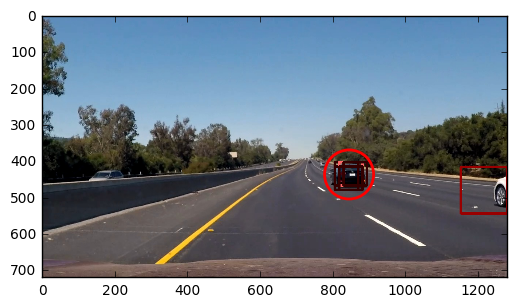

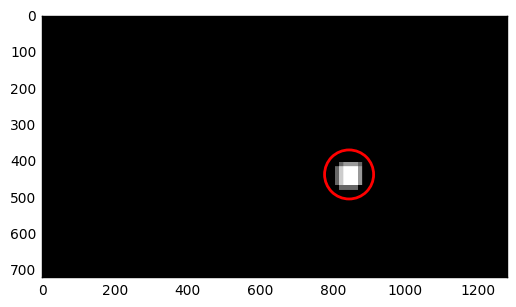

0.0 3.0


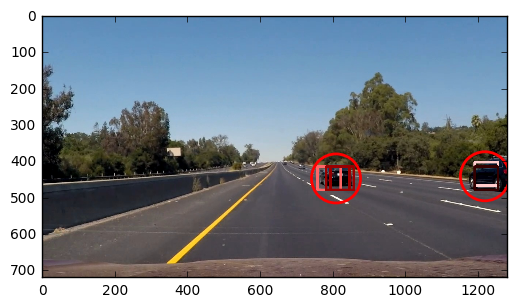

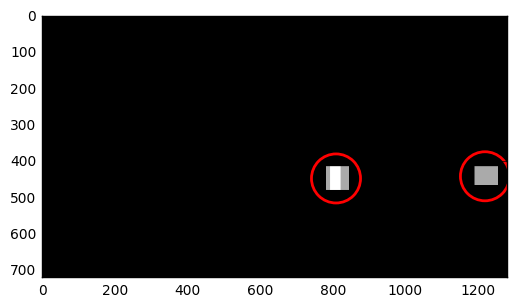

0.0 1.0


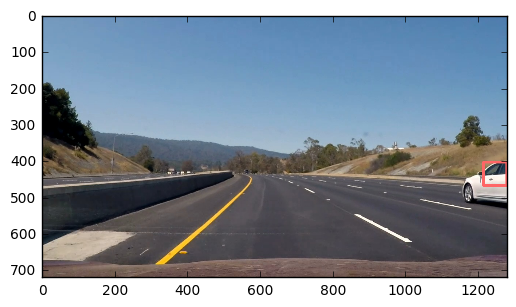

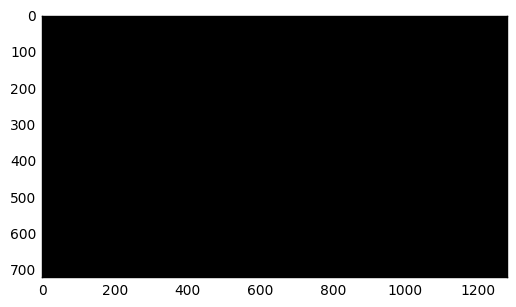

0.0 7.0


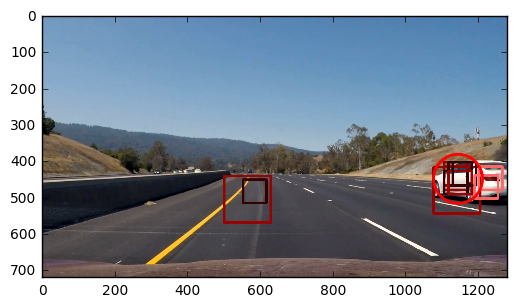

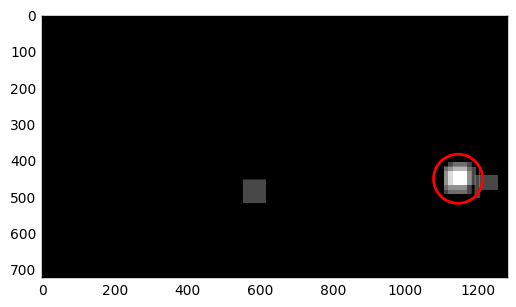

0.0 9.0


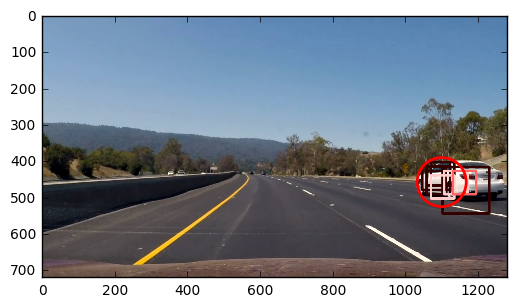

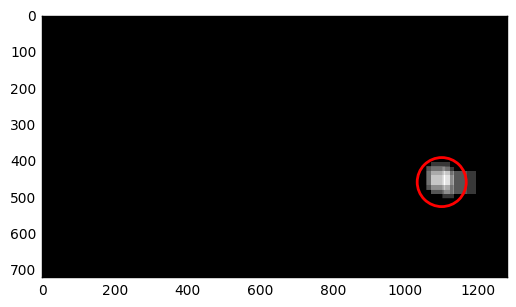

0.0 8.0


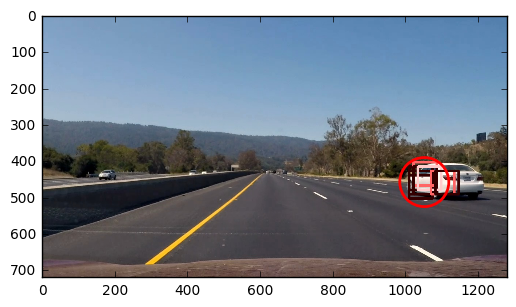

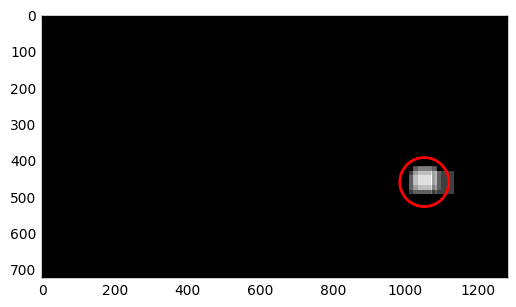

0.0 10.0


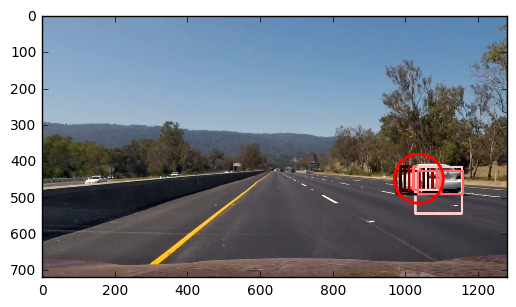

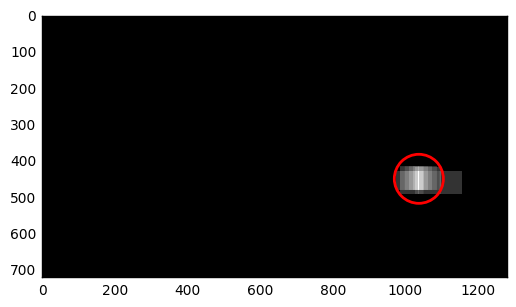

0.0 5.0


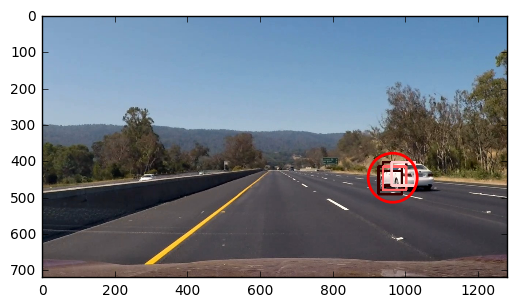

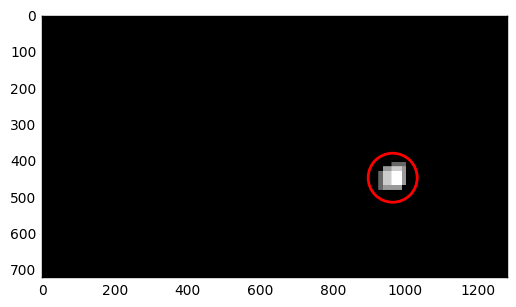

0.0 3.0


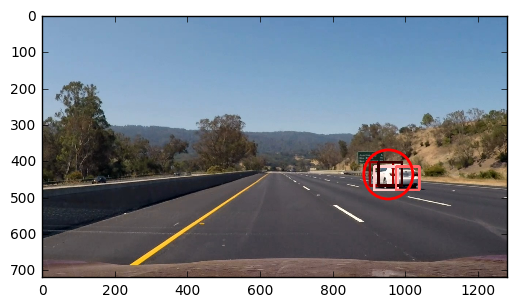

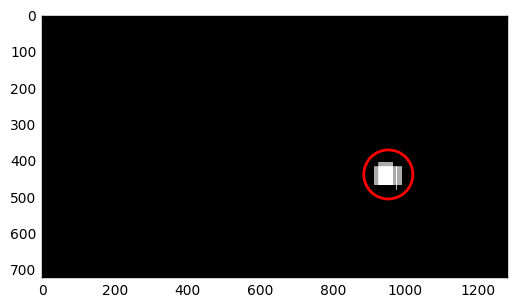

0.0 4.0


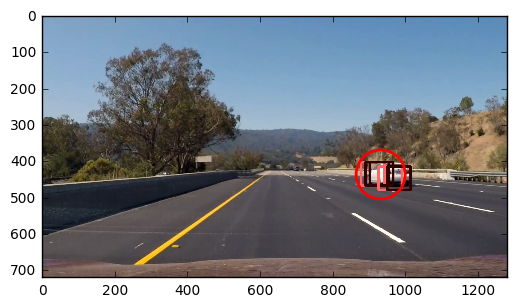

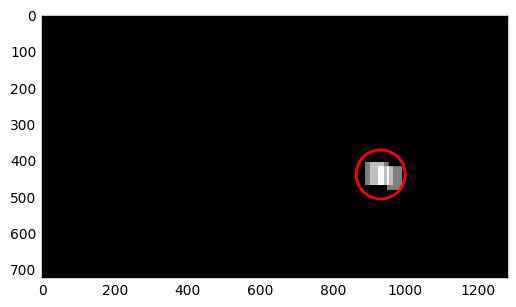

0.0 0.0


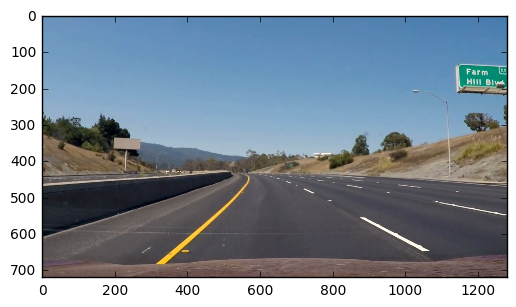

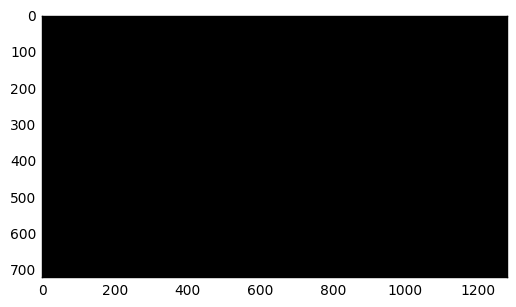

0.0 6.0


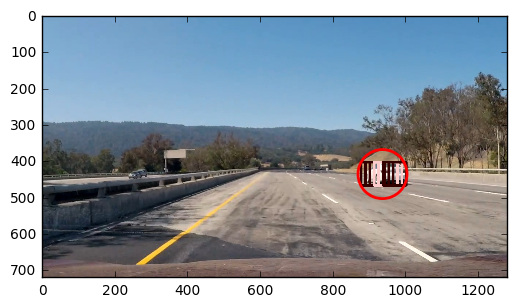

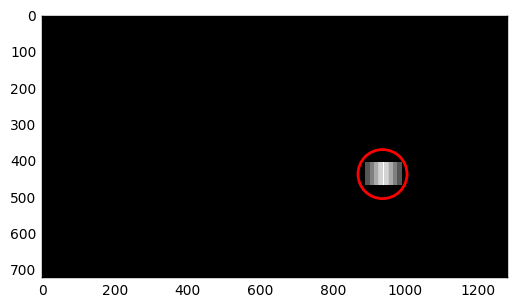

0.0 3.0


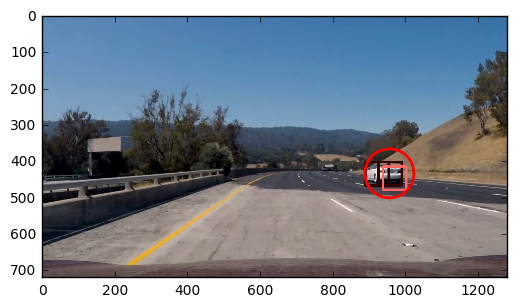

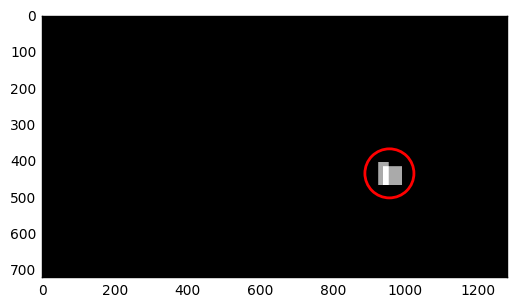

0.0 3.0


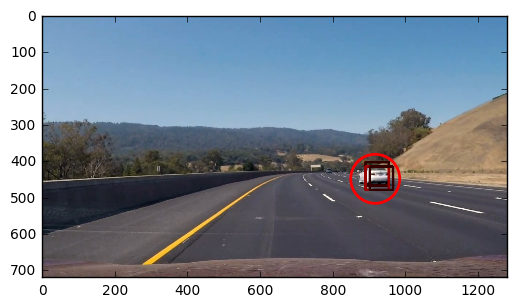

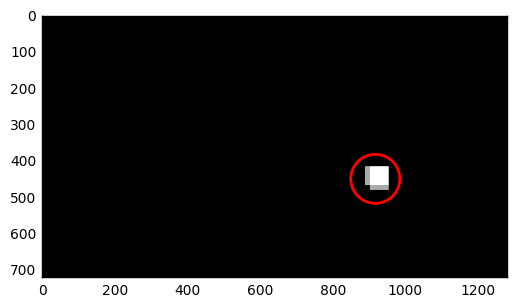

0.0 7.0


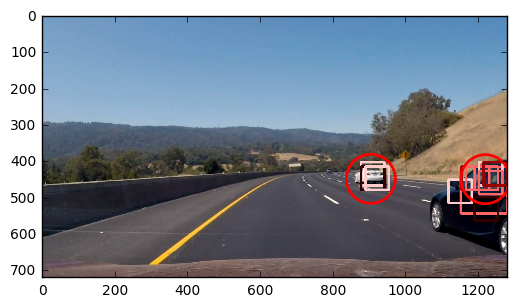

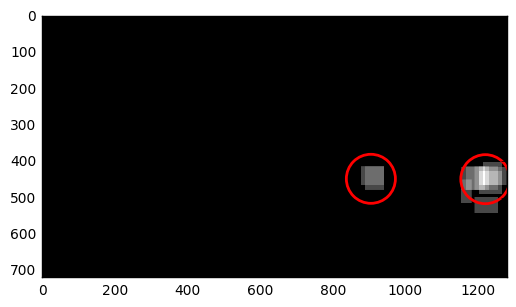

0.0 6.0


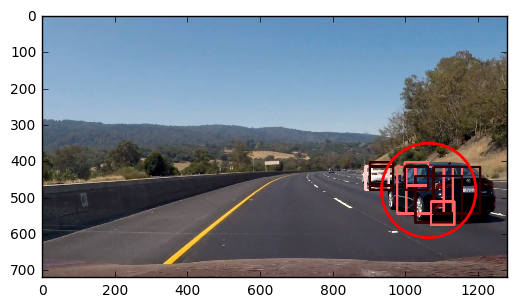

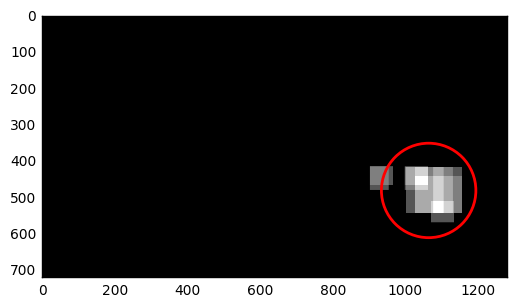

0.0 12.0


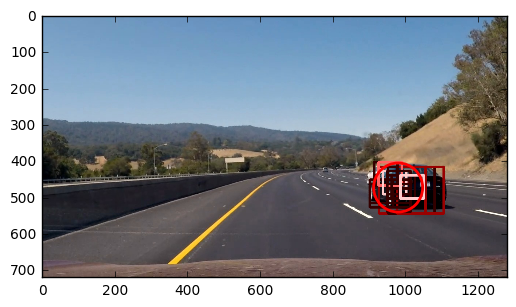

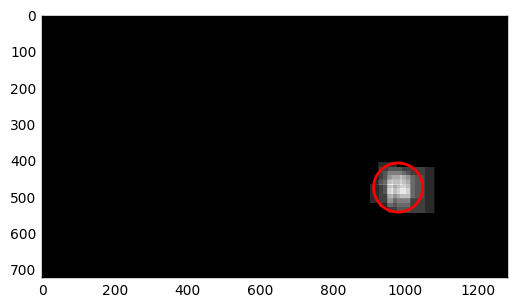

0.0 7.0


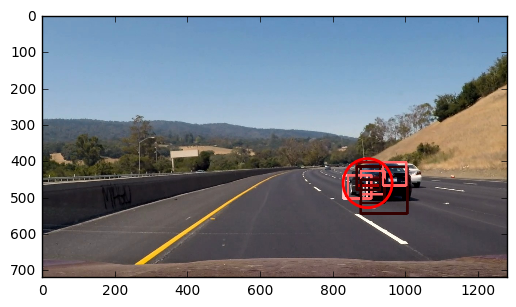

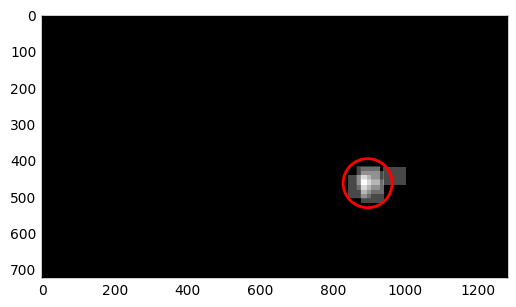

0.0 11.0


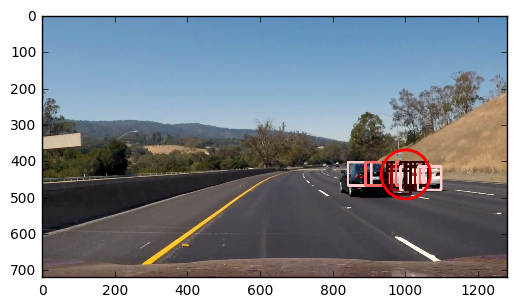

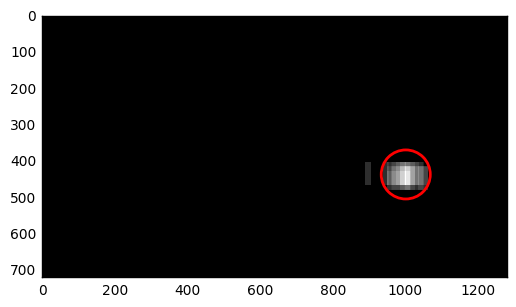

0.0 8.0


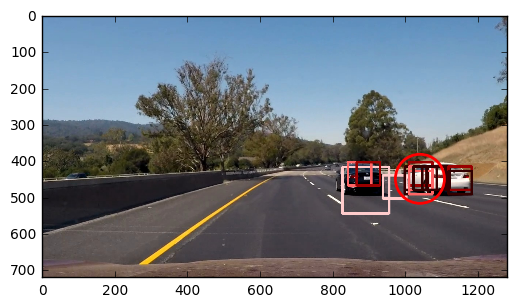

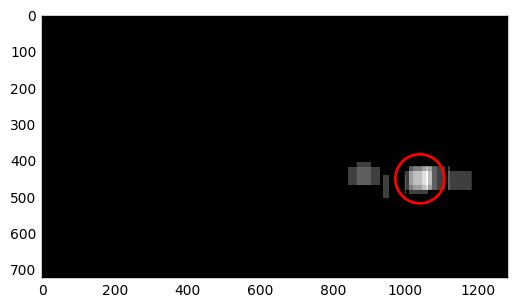

In [381]:
images = glob.glob('extracted_images/*.jpg')

for file in images:
    image = sc.misc.imread(file)
    window_img, windows_pred, windows_proba, heatmap, blobs = pipeline(image = image)
        
#     plt.imshow(window_img)
#     plt.show() 
    
    fig=plt.figure(1)
    ax=fig.add_subplot(1,1,1)
    ax.imshow(window_img)

    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax.add_patch(c)

    plt.show()


    fig=plt.figure(1)
    ax=fig.add_subplot(1,1,1)
    ax.imshow(heatmap, cmap = 'gray')

    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax.add_patch(c)

    plt.show()



### VIDEO

In [210]:
DEBUG = False
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project-video-2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project-video-2.mp4
[MoviePy] Writing video project-video-2.mp4



  4%|▍         | 48/1261 [04:32<1:58:12,  5.85s/it]

KeyboardInterrupt: 

In [64]:
# Extract frame from video if necessary
# Import the necessary packages
# import argparse
# import cv2

vidcap = cv2.VideoCapture("project_video.mp4")
success,image = vidcap.read()
count = 0;
while count <= 1251:
    success,image = vidcap.read()
    if count % 50 == 1:
        cv2.imwrite("extracted_images/frame%d.jpg" % count, image)     # save frame as JPEG file
    count += 1

KeyboardInterrupt: 

In [481]:
# let's try the same with 5 images from myself

In [60]:
car_list_test = ['non-vehicles/Extras/extra42.png',
                'non-vehicles/Extras/extra17.png',
                'non-vehicles/Extras/extra57.png',
                'vehicles/KITTI_extracted/18.png',
                'vehicles/KITTI_extracted/257.png']
car_features = extract_features(car_list_test, cspace=_CSPACE_, cspacehog=_CSPACE_HOG_, spatial_size=_SPATIAL_SIZE_,
                        hist_bins=_HIST_BINS_, hist_range=_HIST_RANGE_, orient=_ORIENT_, pix_per_cell=_PIX_PER_CELL_, 
                        cell_per_block=_CELL_PER_BLOCK_, hog_channel=_HOG_CHANNEL_)

X_feature_testimages = np.asarray(car_features).astype(np.float64) 
# Apply the scaler to X
print('X_feature_testimages.shape:', X_feature_testimages.shape)
scaled_X_feature_testimages = X_scaler.transform(X_feature_testimages)

predictions_testimages = clf.predict(scaled_X_feature_testimages)
predictions_testimages

X_feature_testimages.shape: (5, 1764)


array([ 0.,  0.,  0.,  1.,  1.])